# DASC 10003 Final Project: Forensic Accounting - Detecting Anomalies with Benford’s Law

**Team Roles**:  
- Lead: Ian Horton - Coordination  
- Scribe: Harlie Lockhart  
- Final Presentation Editor: Tre McEntire
- Final Editor for Report - Harlie Lockhart

**Dataset**: SEC Financial Statements (Q1 2020 - Q4 2024)  
**Hypothesis**: Companies that significantly deviate from Benford’s Law in their reported revenue figures will exhibit higher rates of financial outliers (as measured by z-scores) and weaker revenue-expense correlations compared to companies that conform to Benford’s expected distribution

In [12]:
import os
import requests
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from io import BytesIO  # For in-memory ZIP handling if needed

# Define directories
data_dir = 'sec_data'
os.makedirs(data_dir, exist_ok=True)

# List of quarters and URLs (from SEC site)
quarters = [
    ('2020q1', 'https://www.sec.gov/files/dera/data/financial-statement-data-sets/2020q1.zip'),
    ('2020q2', 'https://www.sec.gov/files/dera/data/financial-statement-data-sets/2020q2.zip'),
    ('2020q3', 'https://www.sec.gov/files/dera/data/financial-statement-data-sets/2020q3.zip'),
    ('2020q4', 'https://www.sec.gov/files/dera/data/financial-statement-data-sets/2020q4.zip'),
    ('2021q1', 'https://www.sec.gov/files/dera/data/financial-statement-data-sets/2021q1.zip'),
    ('2021q2', 'https://www.sec.gov/files/dera/data/financial-statement-data-sets/2021q2.zip'),
    ('2021q3', 'https://www.sec.gov/files/dera/data/financial-statement-data-sets/2021q3.zip'),
    ('2021q4', 'https://www.sec.gov/files/dera/data/financial-statement-data-sets/2021q4.zip'),
    ('2022q1', 'https://www.sec.gov/files/dera/data/financial-statement-data-sets/2022q1.zip'),
    ('2022q2', 'https://www.sec.gov/files/dera/data/financial-statement-data-sets/2022q2.zip'),
    ('2022q3', 'https://www.sec.gov/files/dera/data/financial-statement-data-sets/2022q3.zip'),
    ('2022q4', 'https://www.sec.gov/files/dera/data/financial-statement-data-sets/2022q4.zip'),
    ('2023q1', 'https://www.sec.gov/files/dera/data/financial-statement-data-sets/2023q1.zip'),
    ('2023q2', 'https://www.sec.gov/files/dera/data/financial-statement-data-sets/2023q2.zip'),
    ('2023q3', 'https://www.sec.gov/files/dera/data/financial-statement-data-sets/2023q3.zip'),
    ('2023q4', 'https://www.sec.gov/files/dera/data/financial-statement-data-sets/2023q4.zip'),
    ('2024q1', 'https://www.sec.gov/files/dera/data/financial-statement-data-sets/2024q1.zip'),
    ('2024q2', 'https://www.sec.gov/files/dera/data/financial-statement-data-sets/2024q2.zip'),
    ('2024q3', 'https://www.sec.gov/files/dera/data/financial-statement-data-sets/2024q3.zip'),
    ('2024q4', 'https://www.sec.gov/files/dera/data/financial-statement-data-sets/2024q4.zip')
]

# Relevant XBRL tags (common for US GAAP)
revenue_tags = [
    'Revenues', 
    'RevenueFromContractWithCustomerExcludingAssessedTax', 
    'RevenueFromContractWithCustomerIncludingAssessedTax', 
    'SalesRevenueNet'
]
expenses_tags = [
    'OperatingExpenses', 
    'SellingGeneralAndAdministrativeExpense', 
    'CostOfGoodsSold', 
    'OperatingCostsAndExpenses'
]
all_tags = revenue_tags + expenses_tags

# already ran (only needs one pass)

import time

def download_zip(url, save_path, retries=3):
    if os.path.exists(save_path):
        print(f"{save_path} already exists.")
        return

    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36',
        'Accept': '*/*',
        'Accept-Language': 'en-US,en;q=0.9',
        'Connection': 'keep-alive',
    }

    for attempt in range(retries):
        try:
            print(f"Downloading {url} (attempt {attempt + 1})...")
            response = requests.get(url, headers=headers, timeout=30, stream=True)
            response.raise_for_status()

            with open(save_path, 'wb') as f:
                for chunk in response.iter_content(chunk_size=8192):
                    f.write(chunk)
            print(f"Saved to {save_path}")
            return

        except requests.exceptions.HTTPError as e:
            if response.status_code == 403:
                print("403 Forbidden - access denied. Check headers or auth.")
            else:
                print(f"HTTP {response.status_code}: {e}")
        except Exception as e:
            print(f"Error: {e}")
        
        if attempt < retries - 1:
            time.sleep(5)

    print(f"Failed to download {url}")

# Usage
for quarter, url in quarters:
    zip_path = os.path.join(data_dir, f"{quarter}.zip")
    download_zip(url, zip_path)

In [13]:
# Lists to hold data
all_num = []
all_sub = []

for quarter, url in quarters:
    zip_path = os.path.join(data_dir, f"{quarter}.zip")
    print(f"Processing {quarter}...")
    
    with zipfile.ZipFile(zip_path, 'r') as z:
        # Load sub.txt
        sub_df = pd.read_csv(z.open('sub.txt'), sep='\t', dtype={'cik': str, 'sic': str})
        all_sub.append(sub_df[['adsh', 'cik', 'name', 'sic', 'period', 'fy', 'fp']])
        
        # Load num.txt (filtered)
        num_df = pd.read_csv(
            z.open('num.txt'), 
            sep='\t', 
            usecols=['adsh', 'tag', 'ddate', 'uom', 'value'],
            dtype={'adsh': str, 'ddate': str, 'value': float}
        )
        num_df = num_df[num_df['tag'].isin(all_tags)]
        num_df = num_df[(num_df['uom'] == 'USD') & (num_df['value'] > 0)]
        all_num.append(num_df)

# Concatenate
num_data = pd.concat(all_num, ignore_index=True)
sub_data = pd.concat(all_sub, ignore_index=True)

# Merge on adsh
data = num_data.merge(sub_data, on='adsh', how='left')

# Convert dates
data['ddate'] = pd.to_datetime(data['ddate'], format='%Y%m%d', errors='coerce')
data['period'] = pd.to_datetime(data['period'], format='%Y%m%d', errors='coerce')

# Handle missing/outliers preliminarily
data = data.dropna(subset=['value', 'ddate'])
data = data[data['value'] > 0]  # For Benford

# Optional: Sample to top 500 companies by mean assets (if memory issues)
# asset_tag = 'Assets'  # Add if needed, filter num for 'Assets', groupby cik mean, top 500 ciks
# data = data[data['cik'].isin(top_ciks)]

print(data.shape)
data.head()

Processing 2020q1...
Processing 2020q2...
Processing 2020q3...
Processing 2020q4...
Processing 2021q1...
Processing 2021q2...
Processing 2021q3...
Processing 2021q4...
Processing 2022q1...
Processing 2022q2...
Processing 2022q3...
Processing 2022q4...
Processing 2023q1...
Processing 2023q2...
Processing 2023q3...
Processing 2023q4...
Processing 2024q1...
Processing 2024q2...
Processing 2024q3...
Processing 2024q4...
(3350857, 11)


,adsh,tag,ddate,uom,value,cik,name,sic,period,fy,fp
0,0001393883-20-000011,RevenueFromContractWithCustomerExcludingAssess...,2018-12-31,USD,9312000.0,1393883,"DHI GROUP, INC.",7389,2019-12-31,2019.0,FY
1,0001558235-20-000004,Revenues,2018-06-30,USD,55403000.0,1558235,CORPORATE PROPERTY ASSOCIATES 18 GLOBAL INC,6798,2019-12-31,2019.0,FY
2,0001709682-20-000017,Revenues,2018-12-31,USD,68688000.0,1709682,"NESCO HOLDINGS, INC.",7359,2019-12-31,2019.0,FY
3,0001539894-20-000012,Revenues,2016-12-31,USD,177579000.0,1539894,"ATLAS FINANCIAL HOLDINGS, INC.",6331,2018-12-31,2018.0,FY
4,0000067887-20-000011,Revenues,2018-12-31,USD,304045000.0,67887,MOOG INC.,3590,2019-12-31,2020.0,Q1


                               ddate         value  \
count                        3350857  3.350857e+06   
mean   2021-09-28 15:42:03.868848384  1.031394e+09   
min              2000-12-31 00:00:00  1.000000e-02   
25%              2020-06-30 00:00:00  6.945000e+06   
50%              2021-09-30 00:00:00  6.116700e+07   
75%              2022-12-31 00:00:00  3.670000e+08   
max              2031-09-30 00:00:00  1.599300e+12   
std                              NaN  8.126595e+09   

                              period            fy  
count                        3350852  3.238251e+06  
mean   2022-05-09 03:57:32.452569600  2.021761e+03  
min              2004-12-31 00:00:00  2.004000e+03  
25%              2020-12-31 00:00:00  2.021000e+03  
50%              2022-06-30 00:00:00  2.022000e+03  
75%              2023-06-30 00:00:00  2.023000e+03  
max              2024-12-31 00:00:00  2.025000e+03  
std                              NaN  1.496638e+00  


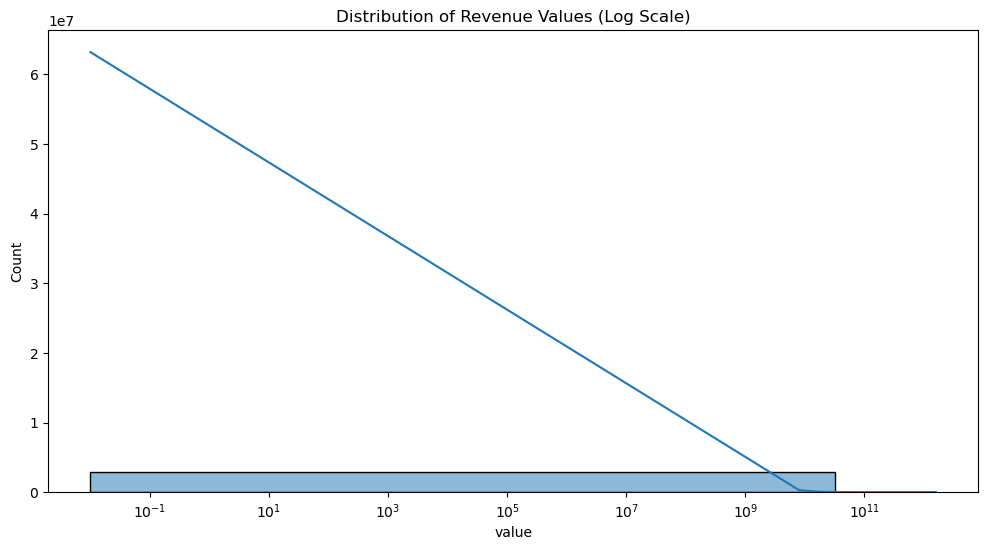

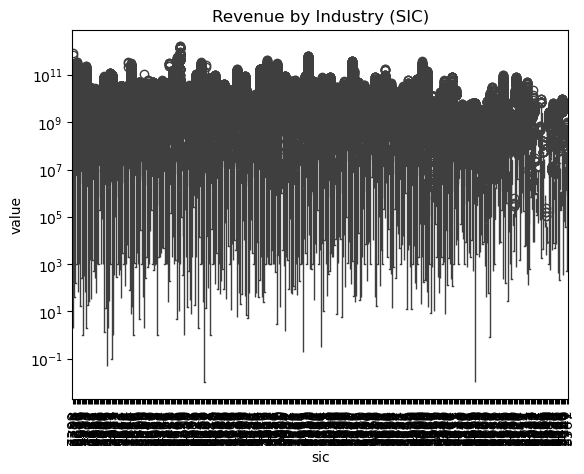

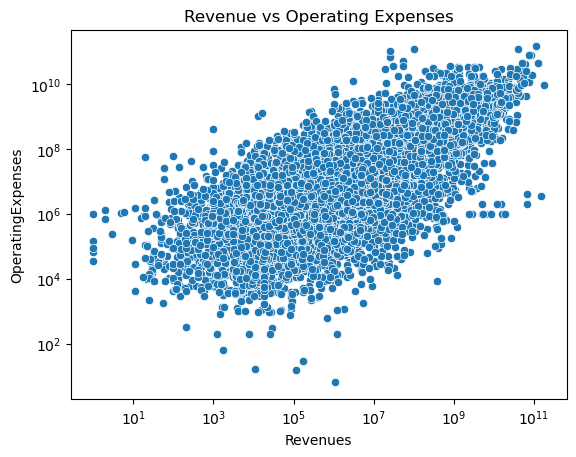

In [6]:
# Summary statistics
print(data.describe())

# Group by tag
data.groupby('tag')['value'].describe()

# Visualizations
plt.figure(figsize=(12, 6))

# Histogram of revenue (log scale)
sns.histplot(data[data['tag'].isin(revenue_tags)]['value'], bins=50, kde=True)
plt.title('Distribution of Revenue Values (Log Scale)')
plt.xscale('log')
plt.show()

# Boxplot by industry (SIC)
sns.boxplot(x='sic', y='value', data=data[data['tag'].isin(revenue_tags)])
plt.title('Revenue by Industry (SIC)')
plt.xticks(rotation=90)
plt.yscale('log')
plt.show()

# Scatter: Revenue vs Expenses
rev_exp = data.pivot_table(index=['cik', 'period'], columns='tag', values='value', aggfunc='first')
rev_exp = rev_exp.dropna(subset=revenue_tags + expenses_tags, how='all')
sns.scatterplot(x=rev_exp[revenue_tags[0]], y=rev_exp[expenses_tags[0]])
plt.title('Revenue vs Operating Expenses')
plt.xscale('log')
plt.yscale('log')
plt.show()

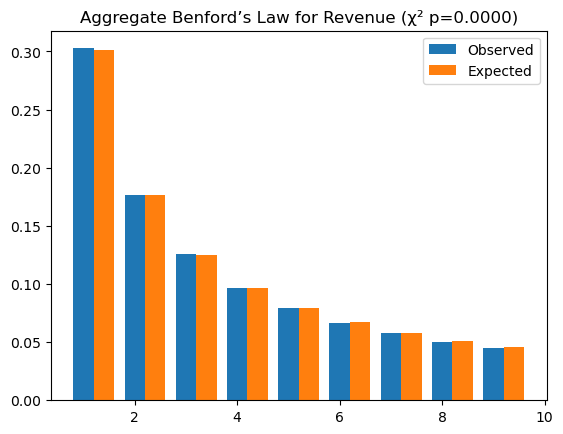

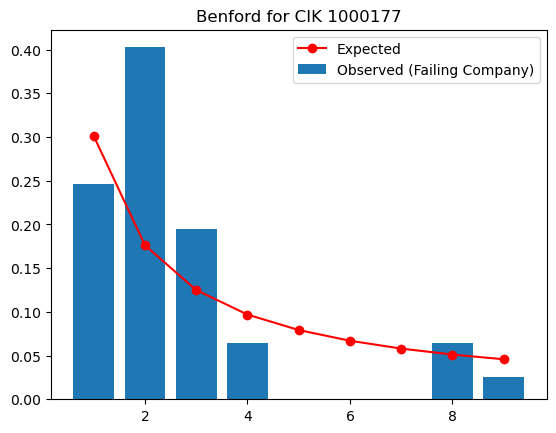

In [15]:
def benford_law(values):
    values = values[values > 0].dropna()
    if len(values) < 10:
        return None, None, None
    
    # Proper leading digit extraction using scientific notation to handle all positive values correctly
    leading_digits = values.apply(lambda x: int(f"{x:e}"[0]))
    observed_counts = pd.Series(leading_digits).value_counts().sort_index().reindex(range(1,10), fill_value=0).values
    n = len(leading_digits)
    
    benford_probs = np.log10(1 + 1 / np.arange(1, 10))
    expected_counts = benford_probs * n
    
    chi2, p = stats.chisquare(observed_counts, expected_counts)
    
    observed = observed_counts / n
    expected = benford_probs
    
    return observed, expected, p

# Apply to revenue per company
benford_results = []
for cik, group in data[data['tag'].isin(revenue_tags)].groupby('cik'):
    values = group['value']
    obs, exp, p = benford_law(values)
    if obs is not None:
        benford_results.append({'cik': cik, 'observed': obs, 'expected': exp, 'benford_p': p})

benford_df = pd.DataFrame(benford_results)

# Flag failing companies (p < 0.05)
benford_df['benford_fail'] = benford_df['benford_p'] < 0.05

# Visualization (aggregate all revenue)
agg_obs, agg_exp, agg_p = benford_law(data[data['tag'].isin(revenue_tags)]['value'])
plt.bar(range(1,10), agg_obs, width=0.4, label='Observed')
plt.bar(np.arange(1,10)+0.4, agg_exp, width=0.4, label='Expected')
plt.title(f'Aggregate Benford’s Law for Revenue (χ² p={agg_p:.4f})')
plt.legend()
plt.show()

# Example for one failing company
fail_cik = benford_df[benford_df['benford_fail']].iloc[0]['cik']
fail_obs = benford_df[benford_df['cik'] == fail_cik]['observed'].values[0]
plt.bar(range(1,10), fail_obs, label='Observed (Failing Company)')
plt.plot(range(1,10), agg_exp, label='Expected', color='red', marker='o')
plt.title(f'Benford for CIK {fail_cik}')
plt.legend()
plt.show()

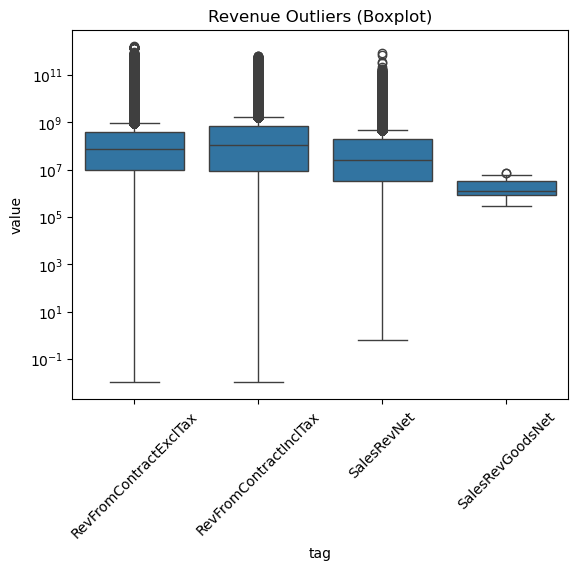

In [11]:
# Z-score per company per tag
data['z_score'] = data.groupby(['cik', 'tag'])['value'].transform(lambda x: (x - x.mean()) / x.std())
data['abs_z'] = abs(data['z_score'])
data['is_outlier'] = data['abs_z'] > 3

# IQR per tag (global, for reference)
for tag in all_tags:
    q1 = data[data['tag'] == tag]['value'].quantile(0.25)
    q3 = data[data['tag'] == tag]['value'].quantile(0.75)
    iqr = q3 - q1
    data.loc[data['tag'] == tag, 'is_outlier_iqr'] = ~data['value'].between(q1 - 1.5*iqr, q3 + 1.5*iqr)

# Your existing code...

sns.boxplot(x='tag', y='value', data=data[data['tag'].isin(revenue_tags)])
plt.title('Revenue Outliers (Boxplot)')
plt.yscale('log')

# Get current tick positions and define short labels (customize these)
tags = data[data['tag'].isin(revenue_tags)]['tag'].unique()
short_labels = [
    'RevFromContractExclTax',  # Abbrev for first tag
    'RevFromContractInclTax',  # Abbrev for second
    'SalesRevNet',             # Abbrev for third
    'SalesRevGoodsNet'         # Abbrev for fourth, if applicable
]

plt.xticks(ticks=range(len(tags)), labels=short_labels, rotation=45)
plt.show()

In [31]:
revenue_tags = [
    'Revenues', 'SalesRevenueNet', 'SalesRevenueGoodsNet', 
    'RevenueFromContractWithCustomerExcludingAssessedTax', 'OperatingRevenue', 
    'NetRevenue', 'InterestAndDividendIncomeOperating', 'NoninterestIncome', 
    'InterestIncomeOperating', 'RevenueFromContractWithCustomerIncludingAssessedTax'
]
expenses_tags = [
    'OperatingExpenses', 'CostOfGoodsSold', 'CostOfGoodsAndServicesSold', 
    'SellingGeneralAndAdministrativeExpense', 'CostOfRevenue', 'CostsAndExpenses', 
    'InterestExpense', 'NoninterestExpense', 'OperatingCostsAndExpenses', 
    'SellingAndMarketingExpense', 'GeneralAndAdministrativeExpense'
]

# Assuming 'data' and 'benford_df' are pre-loaded DataFrames with appropriate columns

# Diagnostic: Check columns and data (optional; remove after debugging)
print("data columns:", data.columns)
print("benford_df columns:", benford_df.columns)
print("Unique tags:", data['tag'].unique())  # Verify tags match lists
print("Rows per cik:", data.groupby('cik').size().describe())  # Data volume per company

# Check for required columns
if 'cik' not in benford_df.columns or 'benford_fail' not in benford_df.columns:
    raise ValueError("Missing required columns in benford_df.")
if 'cik' not in data.columns or 'tag' not in data.columns or 'value' not in data.columns or 'period' not in data.columns:
    raise ValueError("Missing required columns in data.")

# Fix: Drop all columns containing 'benford_fail' to clean artifacts
data = data.drop(columns=[col for col in data.columns if 'benford_fail' in col], errors='ignore')

data = data.merge(benford_df[['cik', 'benford_fail']], on='cik', how='left')

# H1: Chi-square - Association between Benford fail and outlier presence (revenue only)
rev_data = data[data['tag'].isin(revenue_tags)].copy()

# Drop rows where benford_fail is NaN (can't use for analysis)
rev_data = rev_data[rev_data['benford_fail'].notna()]

# Compute z-scores per company (cik) for outlier detection, handling std=0
def safe_z(x):
    if x.std() == 0 or len(x) < 2:
        return np.zeros_like(x)  # Not outlier if constant or single
    return (x - x.mean()) / x.std()

rev_data['z_score'] = rev_data.groupby('cik')['value'].transform(safe_z)
rev_data['abs_z'] = rev_data['z_score'].abs()
rev_data['is_outlier'] = rev_data['abs_z'] > 3  # Common threshold; adjust if needed (e.g., >2.5 for less strict)

# Now create contingency table
contingency = pd.crosstab(rev_data['benford_fail'], rev_data['is_outlier'], dropna=False)

if not rev_data.empty and not contingency.empty and contingency.shape[0] > 0 and contingency.shape[1] > 0:
    try:
        chi2_h1, p_h1, dof, exp = stats.chi2_contingency(contingency)
    except ValueError:
        p_h1 = float('nan')
        print("H1: Invalid contingency table (e.g., all zeros or negative values)")
else:
    p_h1 = float('nan')
    print("H1: No valid data for chi-square test (e.g., empty after filtering or all NaN)")

print(f"H1 Chi-square p-value: {p_h1}")

# H2: t-test - Higher mean |z-score| in failing group
# Use astype(bool) to ensure boolean indexing (preserves columns in empty/object-dtype cases)
fail_z = rev_data[rev_data['benford_fail'].astype(bool)]['abs_z'].dropna()
pass_z = rev_data[~rev_data['benford_fail'].astype(bool)]['abs_z'].dropna()
if len(fail_z) > 0 and len(pass_z) > 0:
    t_stat, p_h2 = stats.ttest_ind(fail_z, pass_z, alternative='greater', nan_policy='omit')
else:
    p_h2 = float('nan')
    print("H2: Insufficient data in one or both groups")
print(f"H2 t-test p-value: {p_h2}")

# H3: Correlation comparison per company
corr_results = []
for cik, group in data.groupby('cik'):
    # Aggregate to total per period to avoid duplicate index
    rev = group[group['tag'].isin(revenue_tags)].groupby('period')['value'].sum()
    exp = group[group['tag'].isin(expenses_tags)].groupby('period')['value'].sum()
    combined = pd.concat([rev, exp], axis=1, keys=['rev', 'exp']).dropna()
    if len(combined) >= 3:  # Lowered threshold; adjust based on data (min 2 for corr, but 3+ for reliability)
        corr = combined.corr().iloc[0, 1]
        corr_results.append({'cik': cik, 'corr': corr})

if not corr_results:
    p_h3 = float('nan')
    print("H3: No companies with sufficient data (at least 3 periods with matching rev/exp) for correlation calculation")
else:
    corr_df_left = pd.DataFrame(corr_results)
    corr_df = corr_df_left.merge(benford_df[['cik', 'benford_fail']], on='cik', how='left')
    # Drop NaN benford_fail in corr_df
    corr_df = corr_df[corr_df['benford_fail'].notna()]
    if not corr_df.empty:
        # Use astype(bool) for same reason
        fail_corr = corr_df[corr_df['benford_fail'].astype(bool)]['corr'].dropna()
        pass_corr = corr_df[~corr_df['benford_fail'].astype(bool)]['corr'].dropna()
        if len(fail_corr) > 0 and len(pass_corr) > 0:
            t_stat_corr, p_h3 = stats.ttest_ind(np.abs(fail_corr), np.abs(pass_corr), alternative='less')  # Weaker = lower abs corr
        else:
            p_h3 = float('nan')
            print("H3: Insufficient data in one or both groups")
    else:
        p_h3 = float('nan')
        print("H3: No correlation data available")
print(f"H3 t-test p-value: {p_h3}")

# Table of results
results_table = pd.DataFrame({
    'Hypothesis': ['H1: More Outliers', 'H2: Higher |z|', 'H3: Weaker Corr'],
    'p-value': [p_h1, p_h2, p_h3]
})
print(results_table)

data columns: Index(['adsh', 'tag', 'ddate', 'uom', 'value', 'cik', 'name', 'sic', 'period',
       'fy', 'fp', 'benford_fail'],
      dtype='object')
benford_df columns: Index(['cik', 'observed', 'expected', 'benford_p', 'benford_fail'], dtype='object')
Unique tags: ['RevenueFromContractWithCustomerExcludingAssessedTax' 'Revenues'
 'OperatingCostsAndExpenses' 'SellingGeneralAndAdministrativeExpense'
 'RevenueFromContractWithCustomerIncludingAssessedTax' 'OperatingExpenses'
 'SalesRevenueNet' 'CostOfGoodsSold']
Rows per cik: count     8303.000000
mean       403.571842
std        615.547956
min          1.000000
25%         54.000000
50%        180.000000
75%        507.000000
max      11992.000000
dtype: float64
H1 Chi-square p-value: 0.5847241503355562
H2 t-test p-value: 0.09606965813297984
H3 t-test p-value: 0.02995028465338702
          Hypothesis   p-value
0  H1: More Outliers  0.584724
1     H2: Higher |z|  0.096070
2    H3: Weaker Corr  0.029950


In [32]:
flagged = benford_df[benford_df['benford_fail']][['cik', 'benford_p']]
flagged.merge(sub_data[['cik', 'name']].drop_duplicates(), on='cik').to_csv('flagged_companies.csv', index=False)

# Implications: If p-values < 0.05, evidence of anomalies in failing group.